# Prediction of Housing Prices in California 1990
This is a direct implementation of **Chapter 2: "End-to-End Machine Learning Project"** from the HandsonML [1] book but with mutiple changes, varied observations and rearragement of sections at my own discretion. Here, we aim to build a machine learning model that performs the supervised univariate multiple regression task of predicting the price of a house based on a set of features obtained through the 1990 California census. The dataset used is a slight modification (see [2] for modifications) of the original California Housing Prices Dataset from the Statlib repository [3].  
First, we import all the usual libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

To get our plots to display in the notebook directly, we need to use the following magic command.

In [2]:
%matplotlib inline

## Data Loading & Exploration
We load in our dataset using `pandas` and perform initial exploratory analysis

In [3]:
df = pd.read_csv("housing.csv")
df.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [4]:
df.shape

(20640, 10)

In [5]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

Our dataset has 20640 samples with 10 feature attributes, as seen above. All of our columns except `ocean_proximity` are numeric float datatypes. The `ocean_proximity` column is returned an an object type but it is actually a categorical value column. Let us view the categories and convert the column type as well.

In [6]:
df["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [7]:
df["ocean_proximity"] = df["ocean_proximity"].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  float64 
 6   households          20640 non-null  float64 
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  category
dtypes: category(1), float64(9)
memory usage: 1.4 MB


Now, we look at the summarised statistics for all the numeric columns using `.describe()`. This will allow us to get an inital understanding about the possibility of presence of outliers, missing values or any such unwanted characteristics in our dataset. 

In [8]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


We can clearly see that `total_bedrooms` has only 20433 values i.e. 207 missing values. We will deal with these later. Also, the maximum value for this column is extremely high and out of place especially when compared to the 3rd quartile (75%). However, the same pattern is observed in `total_rooms`, `households` and `population`; indicating this is not necessarrily an outlier and is represnting a high population density area.  
The `longitude` and `latitude` values cabe be cross-verified with the official Wikipedia page of California [4].  
The `median_income` column has values that are probably a mutiple of some number as a max income of \\$15 does not make sense. On further reading into the source of the dataset, this column has values that are a multiple of \\$10,000 (5 represents \\$50,000).  
Now, we will plot histograms for all the numeric columns.

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

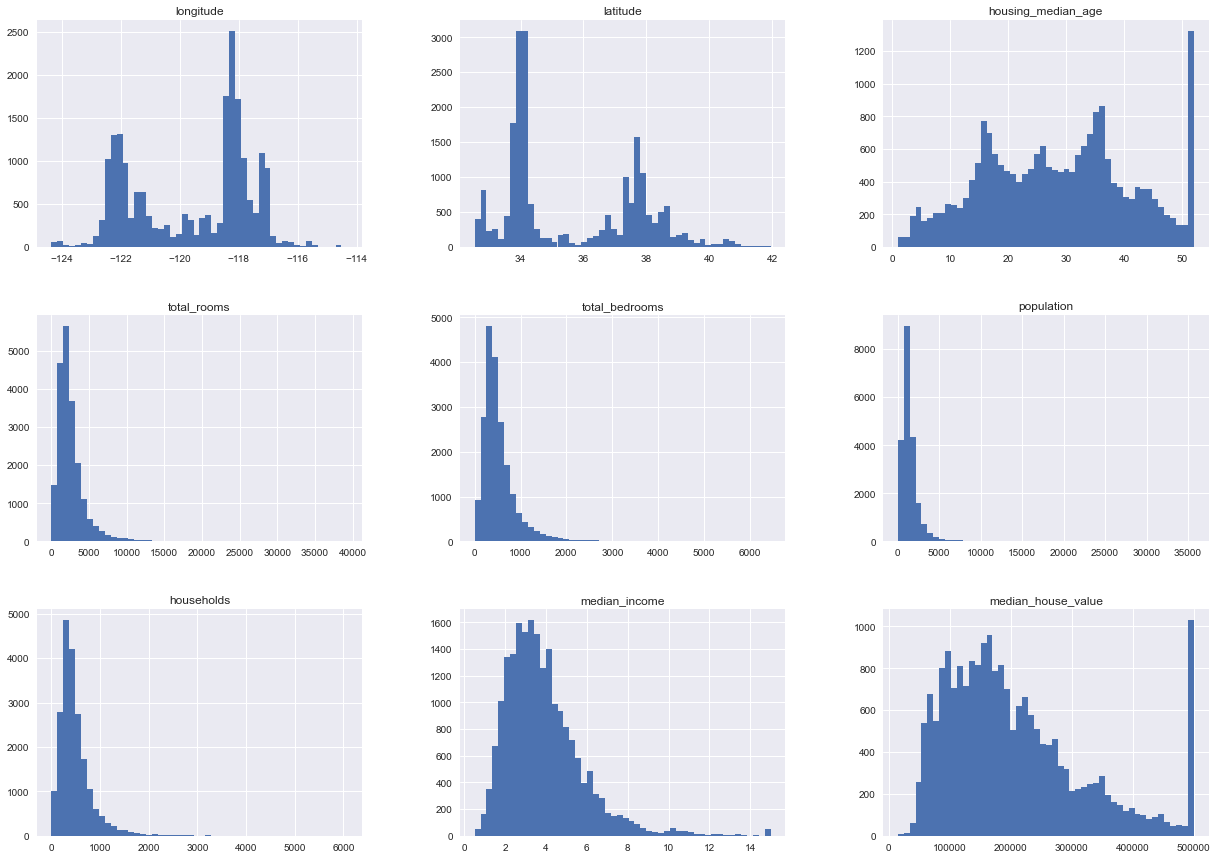

In [9]:
plt.style.use('seaborn')
df.hist(bins=50, figsize=(21,15)) #3x3 plots, so the figure size is passed as a multiple of 3

We present the following initial observations:
* `housing_median_age` and `median_house_value` are both capped. This needs to be processed, especially the latter as it is our target variable.
* `total_rooms`, `total_bedrooms`, `population` and `households` are all very right tail heavy distributions, which may be undesirable depending on the what model we plan on choosing.

<BarContainer object of 5 artists>

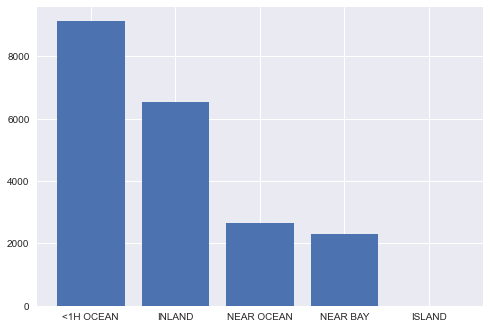

In [10]:
tempdict = dict( df["ocean_proximity"].value_counts() )
plt.bar(tempdict.keys(), tempdict.values())

The `ocean_proximity` column is visualised above. An important observation here is that due to the less samples with `ocean_proximity=ISLAND`, a test sample in the same category might perform poorly compared to samples in other categories.

## Geographical Visualisation

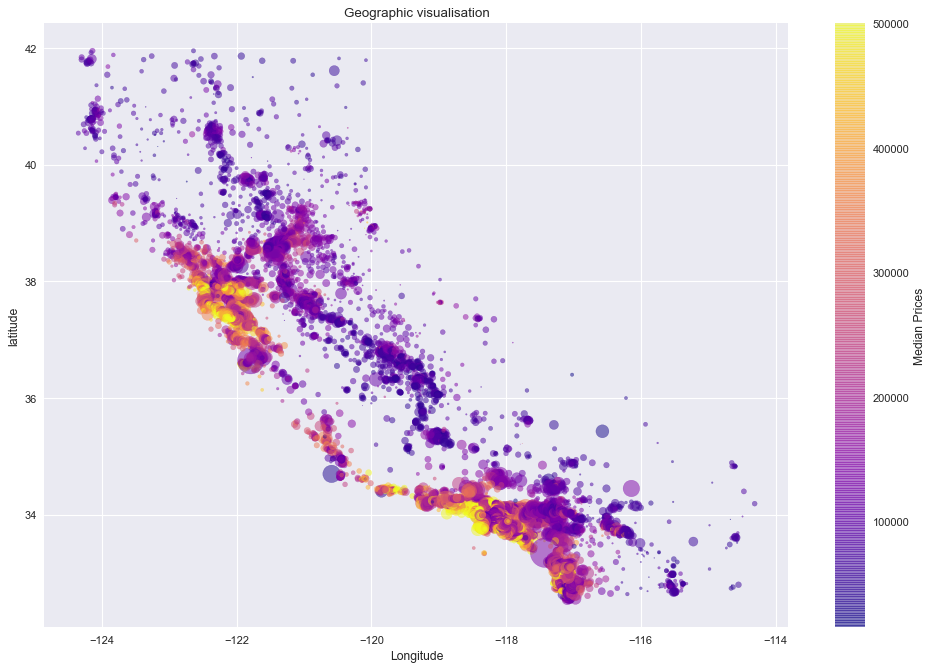

In [11]:
fig, ax = plt.subplots(dpi=80, figsize=(15,10))
sc = ax.scatter(x='longitude', y='latitude', alpha=0.5, data=df, 
           c='median_house_value', cmap='plasma',
           s=df['population']/50)
ax.set_xlabel('Longitude')
ax.set_ylabel('latitude')
ax.set_title('Geographic visualisation')
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Median Prices')
plt.show()

As expected, our plot resembles the shape of California and also indicates higher house prices in denser areas as well as areas closer to the ocean.

## Correlation
We will now look at the correlations among the different features, focusing on the ones that seem highly correlated with `median_house_value`. We do so using the `.corr()` function that gives standard correlation coefficients.

In [12]:
corr_matrix = df.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

We are looking for values that are close to 1 (high positive correlation) or closer to -1 (high negative correlation). Anything that is closer to 0 indicates that the respective columns are mostly uncorrelated.  
Here, the `median_income` has a coorelation coefficient of 0.68 with the house prices. This does make sense practically speaking. Let us plot the two values and see what kind of relation is present between the two features.

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

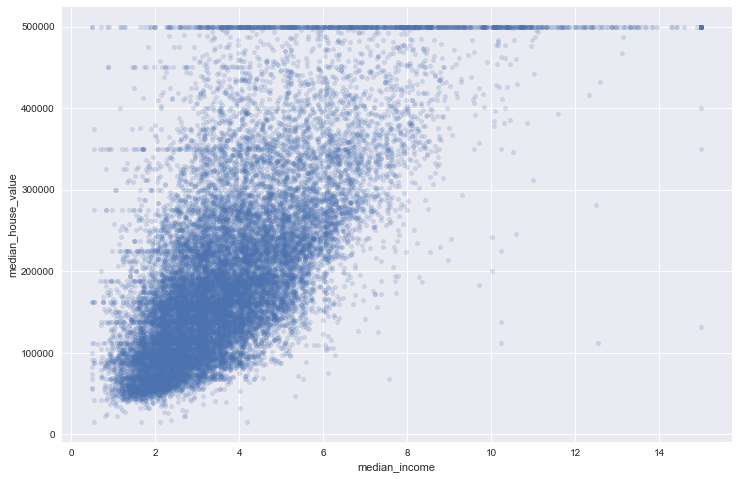

In [13]:
df.plot(x='median_income', y='median_house_value', kind='scatter', alpha=0.2, figsize=(12,8))

We observe a clear upward trend between the two features. Another interesting pattern are the horizontal lines obtained at 500000, 450000, 350000, 280000 (approx.), 220000 (approx) and 4 more smaller ones between 200000 and 100000. The one at \\$500,000 is expected as that the manual cap for the corresponding data but the others require explanation. Ideally, discussing with the data collection team or looking into a similar resource should present an preliminary explanation about this behaviour. For this project, we will choose to ignore it.

## Data Cleaning
As seen above, we need to handle the missing data in the `total_bedrooms` column. There are mainly two ways of doing this, dropping the corresonding samples or filling the empty ones with a statistical parameter like mean or median. `dropna()` function and `Imputer` class can be used to perform the respective methods, depending on our data. Dropping the rows completely preserves the dataset behaviour but results in lesser samples for training and testing. Filling them with mean or median prevents this reductin but can slightly or greatly change the behaviour and distribution of the feature column being filled.    
For our dataset, we can choose to drop the samples with missing value for `total_bedrooms` since there are only 270 of them i.e, about 1% of the total number of samples. If this percantage was larger (greater than 5%), then the other method could be preferred.

In [14]:
df = df.dropna()

In [15]:
df.shape

(20433, 10)

After dropping the required rows, we now have 20433 samples.

## Attribute Combinations
This can be a very important step in data preprocessing and acts as a simple feature extraction method. There are more advanced dimensionality reduction methods like PCA, FDA(for classification), ICA, Subset Selection etc. that are available to extract only the features that have signbificant relations with our target variable.  
For now, we will perform simple arithmetic opertaions on our feature columns to get more signifiant features for our data. This can be done as we have a domain-level understanding of our dataset i.e., what each feature actually indicates and whether it makes practical sense. For example, the total number of rooms in a district do not provide use unless we know the total number of households we have. The information provided by total number of bedrooms is better explained as a ratio with total number of rooms. There are multiple ways of experimenting with this and it is a very iterative process with no perfect answer. The indiaction of imporvement is that the resulting feature should have more correlation than its parent features.   
We will perform 2 of the mentioned combinations below. 

In [16]:
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']

(df.corr())['median_house_value'].sort_values(ascending=False)

c:\users\najju\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\najju\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


median_house_value     1.000000
median_income          0.688355
rooms_per_household    0.151344
total_rooms            0.133294
housing_median_age     0.106432
households             0.064894
total_bedrooms         0.049686
population            -0.025300
longitude             -0.045398
latitude              -0.144638
bedrooms_per_room     -0.255880
Name: median_house_value, dtype: float64

As seen above, our `rooms_per_household` has a greater positive correlation and `bedrooms_per room` has greater negative correlation with our target variable `median_house_value`.

## Handling Categorical values
For most machine learning algorithms, we need to convert categorical data into some other form before passing it to the model. There are two primary ways: label encoding and one-hot encoding. The former is used for ordinal data i.e., data whose values have some order to them that needs to be preserved and can be compared compared arithmetically. For example, ratings 'bad', 'good' and 'best' are ordinal as 'best'>'good'>'bad' is always true. For most other types of categorical data, one-hot encoding does the trick but can result in a significant increase in number of features which in-turn effects training time.  
For our `ocean_proximity` column, we choose one-hot encoding. Scikit-Learn provides a `OneHotEncoder` class [5] to do this but the `get_dummies()` function in Pandas does it more effectively by autocreating the columns that then need to be joined with our dataset.

In [17]:
mod_df = pd.get_dummies(df['ocean_proximity'])
mod_df

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0
...,...,...,...,...,...
20635,0,1,0,0,0
20636,0,1,0,0,0
20637,0,1,0,0,0
20638,0,1,0,0,0


In [18]:
newdf = df.drop('ocean_proximity', axis=1).join(mod_df)
newdf.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,6.984127,0.146591,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,6.238137,0.155797,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,8.288136,0.129516,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,5.817352,0.184458,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,6.281853,0.172096,0,0,0,1,0


In [19]:
newdf.shape

(20433, 16)

We now have 16 numeric features

## Feature Scaling
This is another important step in data preprocessing to ensure that all features have the same scale, which is essential for many machine learning algorithms. We have many methods for scaling but the two most commonly used ones are Min-Max Scaling and Z-score normalization. The former is good when we need to scale all our data in the range of 0-1 (perfect for ANNs) but is sensitive to outliers whereas the latter is robust against outliers but does not bound the data to a specific range. It is important to note that the target variable need not be scaled.  
For our dataset, we will perform Z-score normalization on all except the one-hot encoded columns using the `StandardScaler()` class in Scikit_Learn. It returns a numpy array, so we need to reconvert it to a dataframe.

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_arr = scaler.fit_transform( newdf[['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population',
                                  'households','median_income','rooms_per_household','bedrooms_per_room']] )
scaled_arr

array([[-1.32731375,  1.05171726,  0.98216331, ...,  2.34516291,
         0.62539465, -1.1460242 ],
       [-1.32232256,  1.04235526, -0.60621017, ...,  2.33263161,
         0.3249418 , -0.98725423],
       [-1.33230494,  1.03767426,  1.85576873, ...,  1.78293943,
         1.15059359, -1.44051403],
       ...,
       [-0.82320322,  1.77727236, -0.92388486, ..., -1.14317103,
        -0.09094308,  0.03680837],
       [-0.87311515,  1.77727236, -0.84446619, ..., -1.05513604,
        -0.04101319,  0.11820445],
       [-0.83318561,  1.74918635, -1.00330353, ..., -0.78060586,
        -0.07113779,  0.14049521]])

In [25]:
scaled_arr.shape

(20433, 10)

In [26]:
scaled_df = pd.DataFrame(scaled_arr, 
                         columns=['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population',
                                  'households','median_income','rooms_per_household','bedrooms_per_room'])
scaled_df.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room
0,-1.327314,1.051717,0.982163,-0.803813,-0.970325,-0.973320,-0.976833,2.345163,0.625395,-1.146024
1,-1.322323,1.042355,-0.606210,2.042130,1.348276,0.861339,1.670373,2.332632,0.324942,-0.987254
2,-1.332305,1.037674,1.855769,-0.535189,-0.825561,-0.819769,-0.843427,1.782939,1.150594,-1.440514
3,-1.337296,1.037674,1.855769,-0.623510,-0.718768,-0.765056,-0.733562,0.932970,0.155467,-0.492925
4,-1.337296,1.037674,1.855769,-0.461970,-0.611974,-0.758879,-0.628930,-0.013143,0.342549,-0.706141
5,-1.337296,1.037674,1.855769,-0.785965,-0.770978,-0.893015,-0.801574,0.087213,-0.269721,0.323119
6,-1.337296,1.032993,1.855769,-0.046450,-0.115979,-0.292051,0.038103,-0.111656,-0.201152,-0.347344
7,-1.337296,1.032993,1.855769,0.213936,0.353912,-0.236456,0.386007,-0.395505,-0.255274,0.142951
8,-1.342287,1.032993,1.061582,-0.037298,0.301702,-0.193214,0.249984,-0.942881,-0.458026,0.814662
9,-1.337296,1.032993,1.855769,0.417577,0.401375,0.111238,0.561267,-0.094754,-0.185573,-0.238487


We now need to add in the remaining one-hot encoded columns to get our final processed dataset. This is done after restting their index as `scaled_df` has new index values that are different from `mod_df'

In [46]:
mod_df.index = scaled_df.index

finaltarget = newdf['median_house_value']
finaldf = scaled_df.join(mod_df)
finaldf.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-1.327314,1.051717,0.982163,-0.803813,-0.970325,-0.973320,-0.976833,2.345163,0.625395,-1.146024,0,0,0,1,0
1,-1.322323,1.042355,-0.606210,2.042130,1.348276,0.861339,1.670373,2.332632,0.324942,-0.987254,0,0,0,1,0
2,-1.332305,1.037674,1.855769,-0.535189,-0.825561,-0.819769,-0.843427,1.782939,1.150594,-1.440514,0,0,0,1,0
3,-1.337296,1.037674,1.855769,-0.623510,-0.718768,-0.765056,-0.733562,0.932970,0.155467,-0.492925,0,0,0,1,0
4,-1.337296,1.037674,1.855769,-0.461970,-0.611974,-0.758879,-0.628930,-0.013143,0.342549,-0.706141,0,0,0,1,0
5,-1.337296,1.037674,1.855769,-0.785965,-0.770978,-0.893015,-0.801574,0.087213,-0.269721,0.323119,0,0,0,1,0
6,-1.337296,1.032993,1.855769,-0.046450,-0.115979,-0.292051,0.038103,-0.111656,-0.201152,-0.347344,0,0,0,1,0
7,-1.337296,1.032993,1.855769,0.213936,0.353912,-0.236456,0.386007,-0.395505,-0.255274,0.142951,0,0,0,1,0
8,-1.342287,1.032993,1.061582,-0.037298,0.301702,-0.193214,0.249984,-0.942881,-0.458026,0.814662,0,0,0,1,0
9,-1.337296,1.032993,1.855769,0.417577,0.401375,0.111238,0.561267,-0.094754,-0.185573,-0.238487,0,0,0,1,0


In [48]:
print(finaldf.shape, '\t', finaltarget.shape)

(20433, 15) 	 (20433,)


## Transformation Pipelines
All the above steps performed are transformations on the original data to make it suitable for passing to the our model. We might need to perform the same steps multiple times on idfferent dataset depending on our application and instead of repeating the entire thing anually, we can use the `Pipeline` [6] constructor from Scikit-Learn. It can be used to combine the preprocessing functions into one function-like object to which our data can be passed and the processed dataframe be obtained. Not all proprocessing steps are supported in the pipeline but most of them are and it helps immensely in streamlining our process and being time efficient.  
We will not create a pipeline here in this project but you can read about it from [1] and [6].

## Splitting the Dataset
For any machine learning algorithm process, we need to train it on the training dataset, tune its hyperparameters on the validation dataset and measure its performance on the test dataset. The usual ratios for the 3 are 3:1:1 on the total data. The need for validation set is eliminated by the use of cross-validation methods for hyperparameter tuning, allowing for more data to be set aside for final testing.  
For our dataset, we split into two parts; 70% training data and 30% test data. 

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(finaldf, finaltarget, test_size=0.3, random_state=5)
print(X_train.shape, '\n', X_test.shape, '\n', y_train.shape, '\n', y_test.shape)

(14303, 15) 
 (6130, 15) 
 (14303,) 
 (6130,)


We set `random_state` paarameter as any random integer to ensure reproducible results.

#### The topics below will cover the actual building and training of the models on our data. We will use the 'Gladiator' technique i.e. the models of different algorithms with their default values are trained on the training data and their performance is gauged. The best model is then chosen to be tuned further to improve our results. Throughout this entire process, we should only use the training data.

## Linear Regression
Let us train a standard Linear Regression model on our training data and look at the the results.

In [50]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [54]:
print('Predictions:\t', lin_reg.predict(X_train))
print('True values:\t', y_train)

Predictions:	 [353387.2886613  252523.76280918 374831.14362387 ...  41714.54768234
  39252.7344103  110323.29903027]
True values:	 18373    361200.0
1716     173500.0
16948    464600.0
7475     145700.0
18610    196400.0
           ...   
1038     107200.0
5577     232400.0
3070      62200.0
18817     71000.0
2938      76200.0
Name: median_house_value, Length: 14303, dtype: float64


Just by looking, we can observe errors in our observation. We will quantify this using the root mean square error (RMSE) metric.

In [55]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(y_train, lin_reg.predict(X_train) )
lin_rmse = np.sqrt(lin_mse)
print('RMSE:', lin_rmse)

RMSE: 68002.71187452169


This value indicates that our predictions, on average, are \\$68,000 off the actual house prices on our training data. This is an example of underfitting.

## Decision Tree

In [56]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [57]:
print('Predictions:\t', tree_reg.predict(X_train))
print('True values:\t', y_train)

Predictions:	 [361200. 173500. 464600. ...  62200.  71000.  76200.]
True values:	 18373    361200.0
1716     173500.0
16948    464600.0
7475     145700.0
18610    196400.0
           ...   
1038     107200.0
5577     232400.0
3070      62200.0
18817     71000.0
2938      76200.0
Name: median_house_value, Length: 14303, dtype: float64


In [58]:
tree_mse = mean_squared_error(y_train, tree_reg.predict(X_train) )
tree_rmse = np.sqrt(tree_mse)
print('RMSE:', tree_rmse)

RMSE: 0.0


We get no error, clearly indicating that the model has overfit to the training data.

## Random Forests

In [62]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [63]:
print('Predictions:\t', forest_reg.predict(X_train))
print('True values:\t', y_train)

Predictions:	 [348530.   174576.   451633.06 ...  66770.    72872.98  79470.  ]
True values:	 18373    361200.0
1716     173500.0
16948    464600.0
7475     145700.0
18610    196400.0
           ...   
1038     107200.0
5577     232400.0
3070      62200.0
18817     71000.0
2938      76200.0
Name: median_house_value, Length: 14303, dtype: float64


In [65]:
forest_mse = mean_squared_error(y_train, forest_reg.predict(X_train) )
forest_rmse = np.sqrt(forest_mse)
print('RMSE:', forest_rmse)

RMSE: 18605.73233845042


This might indicate that our Random Forest model is fitting our data well and might be more generalised than the above two.

## Cross-Validation Evaluation
We cannot simply choose our model based on their perfomance on the training data. The real challenge is how the model performs on unseen data. This requires the need of a validation dataset to help choose, then fine tune our model. However, this can be done more effectively and efficiently using cross-validation. The `cross_val_score` is a good generalised metric to compare our models.

In [67]:
from sklearn.model_selection import cross_val_score

def cross_rmse(model):
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
    rmse = np.sqrt(-scores)
    print(rmse.mean())
    
cross_rmse(lin_reg)
cross_rmse(tree_reg)
cross_rmse(forest_reg)

68257.16070852094
70279.11334261918
50023.937362904515


Our Random Forest model performs the best followed by the Linear Regression and the Decision Tree. Even though the tree was overfitting the training data, it gave the worst cross-validation scores.  
Now, we take our Random Forest model and fine tune its parameters

## Hyperparameter Tuning
To do so, we use the `GridSearchCV` class from Scikit-Learn as it allows an easy and automatic way for us to define a set of hyperparameters we want to test and returns the best result.

In [68]:
from sklearn.model_selection import GridSearchCV

param_grid = { 'bootstrap':[True,False], 'n_estimators':[5,10,25,50], 'max_features':[3,8,11,15]}

ft_forest_reg = RandomForestRegressor()

grid_search = GridSearchCV( ft_forest_reg, param_grid, cv=10, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'max_features': [3, 8, 11, 15],
                         'n_estimators': [5, 10, 25, 50]},
             return_train_score=True, scoring='neg_mean_squared_error')

This took quite a while to run but that is expected since we are trying out 2x4x4=32 hyperparameter combinations and then training & testing each combination over 10 times. Now, let us look at our results.

In [69]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=8, n_estimators=50)

In [72]:
cvres = grid_search.cv_results_

for meanscore, params in zip(cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(-meanscore), '\t', params)

59038.11897790234 	 {'bootstrap': True, 'max_features': 3, 'n_estimators': 5}
55042.39551479305 	 {'bootstrap': True, 'max_features': 3, 'n_estimators': 10}
52425.0023587927 	 {'bootstrap': True, 'max_features': 3, 'n_estimators': 25}
51960.97515156578 	 {'bootstrap': True, 'max_features': 3, 'n_estimators': 50}
56454.14576719462 	 {'bootstrap': True, 'max_features': 8, 'n_estimators': 5}
52856.55293949018 	 {'bootstrap': True, 'max_features': 8, 'n_estimators': 10}
51139.6641911967 	 {'bootstrap': True, 'max_features': 8, 'n_estimators': 25}
50170.97246998835 	 {'bootstrap': True, 'max_features': 8, 'n_estimators': 50}
55490.2277129874 	 {'bootstrap': True, 'max_features': 11, 'n_estimators': 5}
52438.11698163315 	 {'bootstrap': True, 'max_features': 11, 'n_estimators': 10}
50919.031992107586 	 {'bootstrap': True, 'max_features': 11, 'n_estimators': 25}
50113.16666653308 	 {'bootstrap': True, 'max_features': 11, 'n_estimators': 50}
55321.77567291332 	 {'bootstrap': True, 'max_features

As seen above, our best result gives an RMSE of \\$49,200 whihc is better than our default model. However, it is still not perfect with the possibility of various tweaks and improvements that will be discussed at the end of this notebook.

## Feature Importance
From our best model, we can get values that indicate the relative importance of each feature to the traget variable.

In [76]:
sorted( zip(grid_search.best_estimator_.feature_importances_, X_train.columns), reverse=True)

[(0.3652785783309616, 'median_income'),
 (0.16420253657086464, 'INLAND'),
 (0.10796398593331023, 'longitude'),
 (0.09191703187575319, 'latitude'),
 (0.06782833280117966, 'bedrooms_per_room'),
 (0.05317660180698691, 'rooms_per_household'),
 (0.043310961543269126, 'housing_median_age'),
 (0.028537145763426666, 'population'),
 (0.021756001752577376, 'total_bedrooms'),
 (0.021277741373962038, 'total_rooms'),
 (0.017540115862242238, 'households'),
 (0.007962005948752572, '<1H OCEAN'),
 (0.006002427760991523, 'NEAR OCEAN'),
 (0.002952903886544488, 'NEAR BAY'),
 (0.00029362878917782513, 'ISLAND')]

This data helps us in feature selection, allowing us to shed unnecessary features that do not contribute significantly to the taret variable. Any feature column with a corresponding value closer to 0 is insignificant. For our data, all the encoded columns except `"INLAND"` are uninformative for predicting the target.

## Test Set Evaluation
Finally, the last step is to calculate our RMSE on the test set.

In [75]:
best_model = grid_search.best_estimator_
test_mse = mean_squared_error(y_test, best_model.predict(X_test))
test_rmse = np.sqrt(test_mse)
test_rmse

48731.769829041696

We get the test root mean squared error of \\$48,731.

## Possible Improvements
* *More algorithms*: Trying out more regression methods in our "Gladiator" step, especially the ones that build upon linear regression like ridge regression, lasso, polynomial regression, regression splines etc. might prove to prform better for the dataset we have. This is a highly subjective process and requires indepth analysis at each step.
* *Feature Selection & Extraction*: We mentioned this during our data preprocessing but after observing the results for `feature_importance`, we can go back and remove some of our feature columns to see if improvement in accuracy or training time can be obtained without compromising the other. The same goes for using feature xtraction methods, but since we have few features compared to the number of samples, it might not produce significant improvements.
* *More tuning*: Hyperparameter tuning is a step that we can do too much off. There are always infinite possible cmbinations for our parameters and trying out a lot of them, both manually and with cross-validation, might be useful depending on the application and project requirements. It is important to remember that this step will increase the total project time, so it is more finding the balance between adequate performance within reasonable amounts of time.

### References:
[1] "Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow", 2nd Edition, bu Aurelien Geron (O'Reilly). Copyright 2019 Aurelien Geron, 978-1-492-03264-9.  
[2] "California Housing", README file from [handson-ml2 github](https://github.com/ageron/handson-ml2/tree/master/datasets/housing), Aurélien Geron.  
[3] R. Kelley Pace, Ronald Barry, "Sparse spatial autoregressions", Statistics & Probability Letters, Volume 33, Issue 3, 1997, Pages 291-297, ISSN 0167-7152, https://doi.org/10.1016/S0167-7152(96)00140-X .  
[4] Wikipedia contributors. (2021, May 1). California. In Wikipedia, The Free Encyclopedia. Retrieved 07:32, May 1, 2021, from https://en.wikipedia.org/w/index.php?title=California&oldid=1020784829 .  
[5] [SkLearn OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)  
[6] [SkLearn Pipeline and its user guide](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline)